## Red line problem

Traings on the red line run every 7-8 minutes on average.

Arriving at the station, it's possible to estimate the time until the next train based on the number of people waiting on the platform.

Fewer people suggests train has just gone and wait is longer. More people suggests train is coming soon. BUT lots and lots of people suggests that the trains are running with delays (and might be time for taxi).

We can treat passengers arriving as a Poisson process (assume they're equally likely to arrive at any time). The rate of passengers arriving (passengers per minute) is unknown, lambda (which we assume is constant).

Arrivals of trains is not Poisson. We can gather data to model the distribution. This data is collected over a long window, taking the time between trains.

If passengers recorded their typical wait time the average wait time would be higher than the data collected from the observation over the longer time window. Why? **Because passengers are more likely to arrive during long wait than short wait.**

Simple example. 50% of trains take 5 mins, 50% take 10 mins. Average is 7.5 mins. But from passengers frame of reference, 2/3 of them would arrive during 10 min window and 1/3 during a 5 minute window so the average would be 8.33 mins.

This is an **observer bias**. 

We can compute the distribution of gaps seen by passengers using the actual distributions of gaps from the longer observation. This is done by taking the actual pmf and then mutliply each value by the likelihood that it will be observed, then normalising.


In [13]:
import thinkbayes
import matplotlib.pyplot as plt

def BiasPmf(pmf, name='', invert=False):
    new_pmf = pmf.Copy(name=name)
    
    for x, p in pmf.Items():
        if invert:
            new_pmf.Mult(x, 1.0/x)
        else:
            new_pmf.Mult(x, x)
        
    new_pmf.Normalize()
    return new_pmf


def UnbiasPmf(pmf, name=''):

    return BiasPmf(pmf, name, invert=True)


We can define the *wait time*, y, as the time between the passenger arriving and the arrival of the next train and the *elapsed time*, x, as the time between the arrival of the previous train and the arrival of a passenger.

We'll refer to the actual distribution of gaps as z and the distribution of gaps seen by passengers as zb, which can be derived as:

zb = x + y

If we have a distribution for zb we can compute a distribution for y.

We can start with a simple example when zb is either 5 mins (p = 1/3) or 10 mins (p = 2/3).

If we arrive at a random time during a 5 min gap, then y is uniform(0,5), or if it's during a 10 min gap, y is uniform(0,10).

Overall distribution is a weighted mixture of these uniform distributions.

In [28]:
def PmfOfWaitTime(pmf_zb):
    metapmf = thinkbayes.Pmf()
    for gap, prob in pmf_zb.Items():
        uniform = MakeUniformPmf(0, gap)
        metapmf.Set(uniform, prob)
        
    pmf_y = thinkbayes.MakeMixture(metapmf)
    return pmf_y

def MakeUniformPmf(low, high):
    pmf = thinkbayes.Pmf()
    for x in MakeRange(low=low, high=high):
        pmf.Set(x, 1)
    pmf.Normalize()
    return pmf

## low and high are range of the uniform distribution

def MakeRange(low, high, skip=10):
    return range(low, high+skip, skip)

def PmfOfWaitTime(pmf_zb):
        metapmf = thinkbayes.Pmf()
        for gap, prob in pmf_zb.Items():
            uniform = MakeUniformPmf(0, gap)
            metapmf.Set(uniform, prob)

        pmf_y = thinkbayes.MakeMixture(metapmf, name='y')
        return pmf_y
        

class WaitTimeCalculator(object):
    
    def __init__(self, pmf_z):
        self.pmf_z = pmf_z
        self.pmf_zb = BiasPmf(pmf_z)
        
        self.pmf_y = PmfOfWaitTime(self.pmf_zb)
        self.pmf_x = self.pmf_y
        
    
## where pmf_z is the unbiased distribution of z and pmf_zb is the biased distribution of gap time, from the passengers perspective

def PredictWaitTime(pmf_zb, pmf_x):
    """Computes the distribution of wait times.
    Enumerate all pairs of zb from pmf_zb and x from pmf_x,
    and accumulate the distribution of y = z - x.
    pmf_zb: distribution of gaps seen by random observer
    pmf_x: distribution of elapsed time
    """
    pmf_y = pmf_zb - pmf_x
    pmf_y.name = 'pred y'
    RemoveNegatives(pmf_y)
    return pmf_y


class ElapsedTimeEstimator(object):
    """Uses the number of passengers to estimate time since last train."""

    def __init__(self, wtc, lam, num_passengers):
        """Constructor.
        pmf_x: expected distribution of elapsed time
        lam: arrival rate in passengers per second
        num_passengers: # passengers seen on the platform
        """
        # prior for elapsed time
        self.prior_x = Elapsed(wtc.pmf_x, name='prior x')

        # posterior of elapsed time (based on number of passengers)
        self.post_x = self.prior_x.Copy(name='posterior x')
        self.post_x.Update((lam, num_passengers))

        # predictive distribution of wait time
        self.pmf_y = PredictWaitTime(wtc.pmf_zb, self.post_x)
        
class Elapsed(thinkbayes.Suite):
    """Represents the distribution of elapsed time (x)."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        Evaluates the Poisson PMF for lambda and k.
        hypo: elapsed time since the last train
        data: tuple of arrival rate and number of passengers
        """
        x = hypo
        lam, k = data
        like = thinkbayes.EvalPoissonPmf(k, lam * x)
        return like
    
def RemoveNegatives(pmf):
    """Removes negative values from a PMF.
    pmf: Pmf
    """
    for val in list(pmf.Values()):
        if val < 0:
            pmf.Remove(val)
    pmf.Normalize()

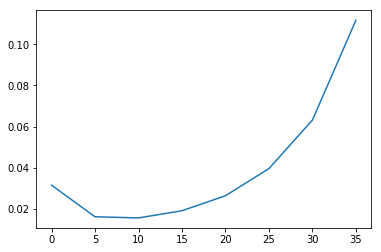

In [58]:
import thinkplot 

upper_bound = 4000
gap_times = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]

nums=[0, 5, 10, 15, 20, 25, 30, 35]

lam=0.0333

n = 220
cdf_z = thinkbayes.MakeCdfFromList(gap_times)
sample_z = cdf_z.Sample(n)
pmf_z = thinkbayes.MakePmfFromList(sample_z)

# compute the biased pmf and add some long delays
cdf_zp = BiasPmf(pmf_z).MakeCdf()
sample_zb = cdf_zp.Sample(n) + [1800, 2400, 3000]

# smooth the distribution of zb
pdf_zb = thinkbayes.EstimatedPdf(sample_zb)
xs = MakeRange(low=60, high = upper_bound)
pmf_zb = pdf_zb.MakePmf(xs)

# unbias the distribution of zb and make wtc
pmf_z = UnbiasPmf(pmf_zb)
wtc = WaitTimeCalculator(pmf_z)

probs = []
for num_passengers in nums:
    ete = ElapsedTimeEstimator(wtc, lam, num_passengers)

    # compute the posterior prob of waiting more than 15 minutes
    cdf_y = ete.pmf_y.MakeCdf()
    prob = 1 - cdf_y.Prob(900)
    probs.append(prob)
    
plt.plot(nums, probs)
plt.show()

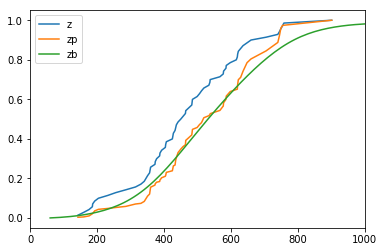

In [60]:
x_arr = []
y_arr = []

for x in cdf_z.Values():
    x_arr.append(x)
    y_arr.append(cdf_z.Prob(x))
    
plt.plot(x_arr,y_arr, label='z')


x_arr = []
y_arr = []

for x in cdf_zp.Values():
    x_arr.append(x)
    y_arr.append(cdf_zp.Prob(x))
    
plt.plot(x_arr, y_arr, label='zp')

x_arr = []
y_arr = []


cdf_zb = pmf_zb.MakeCdf()
for x in cdf_zb.Values():
    x_arr.append(x)
    y_arr.append(cdf_zb.Prob(x))
    
plt.plot(x_arr, y_arr, label='zb')
plt.legend()
plt.xlim(0,1000)
plt.show()



* *pmf_y* is the distribution of wait time
* *pmf_x* is the distribution of elapsed time, which is the same as the distribution of wait time

Why? Because for a given value of zp the distribution y is uniform from 0 to zp and x = zp - y, so we know the distribution of x is also uniform from 0 to zp.

## Predicting wait times

Suppose we arrive at platform and there are 10 passengers waiting. What is the predicted wait time for next train?

We start with the true distribution of z and the passenger arrival rate, lambda = 2.

* Use the distribution of z to compute prior distribution of zb (time between trains as seen by passenger).
* Use the number of passengers to estimate the distribution of x (elapsed time since last train)
* Use y = zp - x to get distribution of y



In [ ]:
wtc = WaitTimeCalculator(pmf_z)

ete = ElapsedTimeEstimator(wtc, lam=2.0/60, num_passengers=15)

class ElapsedTimeEstimator(object):
    
    def __init__(self, wtc, lam, num_passengers):
        self.prior_x = Elapsed(wtc.pmf_x)
        
        self.post_x = self.prior_x.Copy()
        self.post_x.Update((lam, num_passengers))
        
        self.pmf_y = PredictWaitTime(wtc.pmf_zb, self.post_x)
        
class Elapsed(thinkbayes.Suite):
    
    def Likelihood(self, data, hypo):
        x = hypo
        lam, k = data
        like = thinkbayes.EvalPoissonPmf(lam * x, k)
        return like
    
def PredictWaitTime(pmf_zb, pmf_x):
    pmf_y = pmf_zb - pmf_x # since y = zb - x
    # subtraction envokes Pmf.__sub__ which enumerates all pairs of zb and x, computes the differences and adds results to pmf_y
    pmf_y.name = 'pred y'
    RemoveNegatives(pmf_y) # Get rid of negative values as they're impossible
    return pmf_y



Where *prior_x* and *posterior_x* are the prior and posterior distributions of elapsed time, *pmf_y* is the predictive distribution of wait time.

This calls *Elapsed* which is a Suite that represents the hypothetical distribution of *x*. Prior dist of x comes from WaitTimeCalculator. Data consists of arrival rate (lambda) and number of passengers, this allows us to compute the posterior distribution.

Likelihood of data is probability of getting *k* arrivals in *x* time, give the rate of arrival lambda.

## Estimating arrival rate

So far we have assumed we know 1) distribution of gaps and 2) passenger arrival rate.

We can drop the second assumption and instead model this. How? Each time you arrive, can note the time of day and number of passengers and then record wait time and number of passengers to arrive while you are waiting.

You can compute an average arrival rate over your observations (point estimate) or can compute a posterior distribution for lambda.

We can define an 'ArrivalRate' class, which has a similar Likelihood to Elapsed. Instead of lambda being part of the data, y is.

Our estimator class builds hypos which is a sequence of hypothetical values for lam. It then builds a prior dist and uses the for loop to update the prior in order to obtain the posterior.



In [ ]:
import numpy as np

class ArrivalRate(thinkbayes.Suite):
    
    def Likelihood(self, data, hypo):
        lam = hypo
        y, k = data
        like = thinkbayes.EvalPoissonPmf(lam * y, k)
        return like
    
class ArrivalRateEstimator(object):
    
    def __init__(self, passenger_data):
        low, high = 0, 5
        n = 51
        
        hypos = np.linspace(low, high, n) / 60
        
        self.prior_lam = ArrivalRate(hypos)
        
        self.post_lam = self.prior_lam.Copy()
        for k1, y, k2 in passenger_data:
            self.post_lam.Update((y, k2))
            


## Incorporating uncertainty

When we have uncertainty about a given parameter (input into analysis) we can take it into account using the following steps:

1. Implement analysis using a deterministic value of the parameter.
2. Compute distibution of uncertain param
3. Run analysis for each value of param, generate set of predictive distributions.
4. Compute a mixture of the predictive distributions, using the weights from the distribution of the parameter. 

We have done 1 and 2 above, 3 and 4 can be handled with WaitMixtureEstimator class.

This takes a WaitTimeCalculator with distribution of zb and the ArrivalTimeEstimator with the distribution of lam. It makes a meta-Pmf to map from each possible distribution of y to its probability. ElapsedTimeEstimator is used to compute corresponding dist of y for a given value of lam and stores it in meta-Pmf. Then the mixture is computed with MakeMixture.

This gives us similar results to our point estimate of lam, so not necessary. System response is approx linear.

But, important to include variability if the system response is non-linear (small changes could cause big output shift).

In [ ]:
class WaitMixtureEstimator(object):
    
    ## wtc is WaitTimeCalculator, are is ArrivalTimeEstimator
    def __init__(self, wtc, are, num_passengers=15):
        self.metapmf = thinkbayes.Pmf()
        
        for lam, prob in sorted(are.post_lam.Items()):
            ete = ElapsedTimeEstimator(wtc, lam, num_passengers)
            self.metapmf.Set(ete.pmf_y, prob)
            
        self.mixture = thinkbayes.MakeMixture(self.metapmf)

## Decision analysis

We can use the number of passengers on platform to predict the distribution of wait times. Now we can decide on when to leave the platform to get a taxi.

Our max wait time before we will miss our connection is 15 mins. What is prob that y exceeds 15 mins, can we get this as a func of the number of passengers. We can run our predicting wait times analyssi for a range of passenger numbers.

However, it's hard to predict the frequency of long delays (as these are rare) but they're an important part of the analysis. 

Can estimate that 3 long delays occur per year based on observations but note that observations are biased. So treat this as a sample of zb not z. 

A total of 220 trips taken, can take observed gap times, generate sample of 220 gaps and compute the Pmf. We can bias the pmf_z to get a distribution of zb. We can draw a sample from this and add in larger delays (30, 40 and 50 minutes).

Note Cdf.Sample more efficient than Pmf.Sample so easier to convert first.

Use sample of zb to estimate a Pdf with Kernel Density Estimation, then convert Pdf to Pmf.

Unbias distribution of zb to get dist of z, which can be used for WaitTimeCalculator.

Then compute probability of long wait. Can take number of passengers and compute prob that wait time exceeds a given time.

We can decide what % chance we are willing to take. If we set this at 10% then we should leave and get a taxi if passengers exceeds 30.

Could extend by taking cost of missing connect/cost of taking taxi and choose threshold that minimises expected cost.

Note, model is general and will not account for special events occuring on certain days etc.

We did assume that we knew distribution of z, but from a single passenger point of view it's hard to estimate.

